In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import random
import pandas as pd
import numpy as np
import re

In [2]:
# Importing the csv file
df = pd.read_csv(os.getcwd()+'/missed/'+'missed.csv')

In [3]:
# Rename columns
df = df.rename(columns = {'Unnamed: 0':'column0','estatura_(cm)':'estatura',
                          'hecho_ocurrido_el':'fecha_desaparicion'})

# Remove the innnecesary columns 
df = df.drop(['column0','fecha_denuncia','raza'], axis = 1)

# Check the data type and nulls
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3542 entries, 0 to 3541
Data columns (total 5 columns):
edad                  3506 non-null object
estatura              3418 non-null object
fecha_desaparicion    3542 non-null object
sexo                  3528 non-null object
ubigeo                3514 non-null object
dtypes: object(5)
memory usage: 138.5+ KB


In [4]:
# Take a brief look to the messy data
df.loc[np.where(df.estatura.isnull() == True)].head()

,edad,estatura,fecha_desaparicion,sexo,ubigeo
10,14,NaN,"Miércoles, 4 Diciembre, 2019 - 00:00",Femenino,"Lima,Lima,San Martin de Porres"
36,14,NaN,"Domingo, 1 Diciembre, 2019 - 00:00",Femenino,"Junín,Chanchamayo,Pichanaqui"
113,13,NaN,"Viernes, 22 Noviembre, 2019 - 16:00",Femenino,"Junín,Chanchamayo,Pichanaqui"
116,15,NaN,"Viernes, 22 Noviembre, 2019 - 09:00",Femenino,"Junín,Chanchamayo,Pichanaqui"
165,13,NaN,"Sábado, 16 Noviembre, 2019 - 20:00",Femenino,"Junín,Satipo,Satipo"


In [5]:
def convert_sp_to_en_dates(df):
    # Function that converts string dates to datetime

    spDays = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
    spMonths = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto',
               'Septiembre','Octubre','Noviembre','Diciembre']
    enDays = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    enMonths = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',
               'Dec']
    
    df['fecha_desaparicion2'] = df['fecha_desaparicion']
    
    for spday,enday in zip(spDays,enDays):
        df['fecha_desaparicion2'].replace({spday:enday},inplace=True,regex=True)

    for spmonth,enmonth in zip(spMonths,enMonths):
        df['fecha_desaparicion2'].replace({spmonth:enmonth},inplace=True,regex=True)
    
    df['fecha_desaparicion2'].replace({'-':''},inplace=True,regex=True)
    df['fecha_desaparicion2'] = pd.to_datetime(df.fecha_desaparicion2, errors='coerce')
    
    return df

In [6]:
# Doing some data cleaning

# changing str to numeric and replace the missing values with the mean
df['edad2'] = pd.to_numeric(df.edad, errors='coerce', downcast = 'integer')
df['edad2'] = df['edad2'].fillna(int(df.edad2.mean()))

# changing str to numeric, some conversion to meters and replace the missing values 
# with the mean
df['estatura2'] = pd.to_numeric(df.estatura, errors='coerce')
df['estatura2'] = df[df.estatura2>1.9].estatura2/100
df['estatura2'] = df['estatura2'].fillna(df.estatura2.mean())
df['estatura2'] = df['estatura2'].round(2)

# Convert string dates to datetime
convert_sp_to_en_dates(df)

# Separate year and month
df['año'] = df['fecha_desaparicion2'].map(lambda x : x.year)
df['mes'] = df['fecha_desaparicion2'].map(lambda x : x.month)

# Split ubigeo
df[['departamento','provincia','distrito']] = df.ubigeo.str.split(",", expand = True)

In [7]:
# Take a brief look to the cleaned data to check last mistakes
df.groupby('sexo')['año'].count()

sexo
15              1
16              2
17              1
Femenino     2564
Masculino     960
Name: año, dtype: int64

In [8]:
# Doing some final corrections in the column 'sexo' and assigning 'Femenino' per default to 
# avoid inconsistent data
df.loc[(df['sexo']!='Femenino')& (df['sexo']!='Masculino'),'sexo'] = 'Femenino'

# Removing the innecesary columns
df = df.drop(['edad','fecha_desaparicion','estatura','fecha_desaparicion2','ubigeo'], axis = 1)

# Categorizing edad in etapas
df['edad_categoria'] = pd.cut(df['edad2'], bins = [0,12,18,30,60],include_lowest=True)

In [9]:
df.head()

,sexo,edad2,estatura2,año,mes,departamento,provincia,distrito,edad_categoria
0,Masculino,13.0,1.5,2019,12,Lima,Lima,Lima,"(12.0, 18.0]"
1,Femenino,14.0,1.5,2019,12,Huánuco,Huánuco,Santa María del Valle,"(12.0, 18.0]"
2,Femenino,17.0,1.5,2019,12,Lima,Lima,Los olivos,"(12.0, 18.0]"
3,Femenino,13.0,1.5,2019,12,Lima,Lima,Los olivos,"(12.0, 18.0]"
4,Femenino,15.0,1.5,2019,12,Piura,Piura,Castilla,"(12.0, 18.0]"


In [10]:
# It seems that the registration on the web started on 2016.
# Before 2018 there were 21 registers, so will use the data >= 2018
len(df[df['año']<2018])

21

Text(0.5, 1.1, 'Desapariciones en Perú 2018-2019')

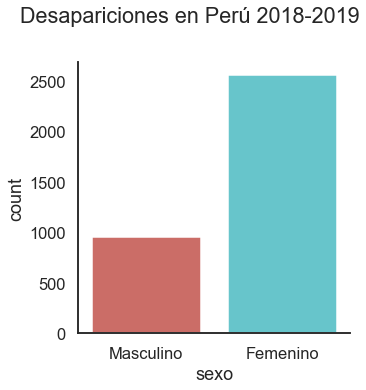

In [11]:
# Doing some visualizations
# Total of missing people 2018, 2019
sns.set(style="white", context="talk")
g = sns.catplot(x='sexo',palette='hls', data=df[df['año']>2017], kind='count')
g.fig.suptitle('Desapariciones en Perú 2018-2019', y=1.1)

Text(0.5, 1.02, 'Desapariciones 2018-2019')

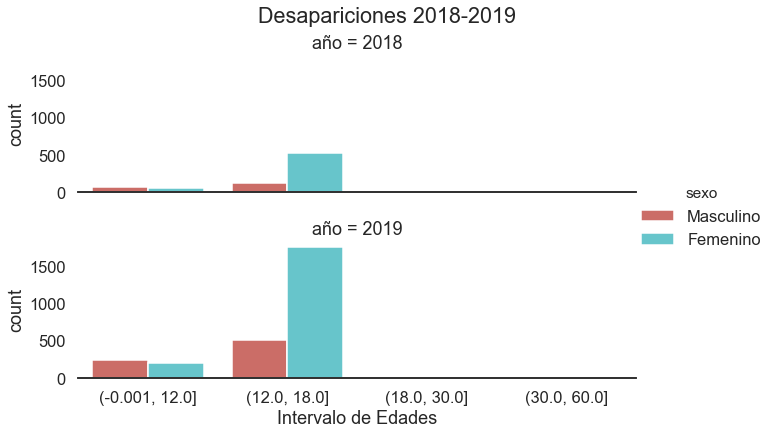

In [13]:
# Missing People by Years
# Frequent missing people : between 12 - 18 years old
# Women are kidnapped x3 than men

sns.set(style="white", context="talk")
g = sns.catplot(x='edad_categoria', hue='sexo', row = 'año',palette='hls', kind='count',
                data=df[df['año']>2017], aspect=3, height=3)

(g.set_xlabels('Intervalo de Edades').despine(left=True))

g.fig.suptitle('Desapariciones 2018-2019', y=1.02)

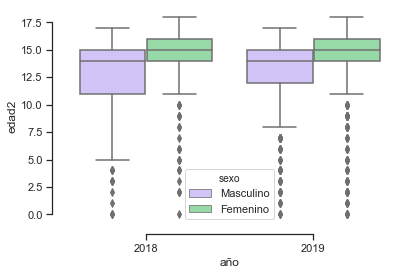

In [14]:
# Missing people by Ages
# The mean Missed Women are 15 years while Men are aprox. 14 years old

sns.set(style="ticks", palette="pastel")

sns.boxplot(x='año', y ='edad2', hue='sexo', data=df[df['año']>2017], palette=["m", "g"])
sns.despine(offset=10, trim=True)

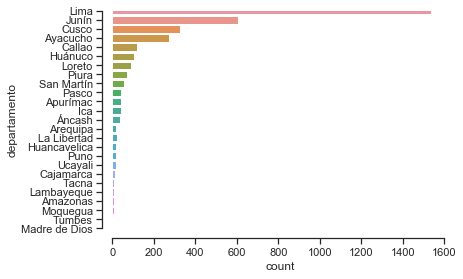

In [68]:
# Missing people by departament
df['desaparecido'] = 1
subtot_dep = (df.groupby(["departamento"])['desaparecido'].aggregate(np.sum).
              reset_index().sort_values(by='desaparecido', ascending=False))

sns.set(style="ticks", palette="pastel")

sns.countplot(y='departamento', data=df[df['año']>2017], 
              order = subtot_dep['departamento'], orient='h')
sns.despine(offset=10, trim=True)